<a href="https://colab.research.google.com/github/mrdo19111911/3D-Loading-Divide-space-2.0/blob/main/3D_Loading_Divide_space_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numba
from numba import njit

In [2]:
import random as rd
import time
import graphviz
from numba.typed import List
%autosave 60


Autosaving every 60 seconds


# To do
1- update item_pos_list

2- backup state of boxes. to reuse

3- 

In [3]:
DATA_SIZE=5
ROTATE_FIX=   np.array([
        [0,1,2],
        [0,2,1],
        [1,0,2],
        [1,2,0],
        [2,1,0],
        [2,0,1]], np.int_)

In [4]:
class Bin:
    def __init__(self, size):
        self.size =size
    def print(self):
        print("size", self.size)
class Item:
    def __init__(self, size):
        self.size= size
    def print(self):
        print("data", self.size)

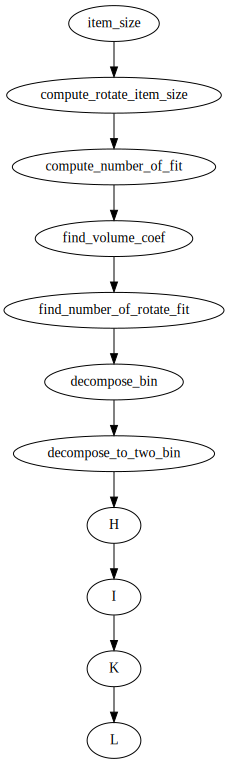

In [5]:
dot = graphviz.Digraph(comment='The Round Table')
dot.node('A', "item_size")  # doctest: +NO_EXE
dot.node('B', "compute_rotate_item_size")  # doctest: +NO_EXE
dot.node('C', "compute_number_of_fit")  # doctest: +NO_EXE
dot.node('D', "find_volume_coef")  # doctest: +NO_EXE
dot.node('E', "find_number_of_rotate_fit")  # doctest: +NO_EXE
dot.node('F', "decompose_bin")  # doctest: +NO_EXE
dot.node('G', "decompose_to_two_bin")  # doctest: +NO_EXE


dot.edges(['AB', 'BC',"CD", "DE","EF", "FG", "GH", "HI", "IK", "KL"])
dot

In [6]:
@njit
def compute_rotate_item_size(size, k):
    new =  ROTATE_FIX[k]
    # aa =  [size[new[0]], size[new[1]], size[new[2]]]
    new_size =  np.concatenate((np.array([size[new[0]], size[new[1]], size[new[2]]], np.int_) , size[3:]   ))
    
    return new_size

In [7]:
@njit
def compute_number_of_fit(bin_size,item_size): #no rotate
    M_l=math.floor(bin_size[0]/item_size[0])
    M_w=math.floor(bin_size[1]/item_size[1])
    M_h=math.floor(bin_size[2]/item_size[2])
    result = np.empty((4), np.int_)
    result[0]= M_h*M_l*M_w
    result[1]= M_l
    result[2]= M_w
    result[3]= M_h
    return result

@njit

def find_volume_coef(bin_size,item_size ):
    a=math.floor(bin_size[0]/item_size[0])* math.floor(bin_size[1]/item_size[1])* math.floor(bin_size[2]/item_size[2])
    if a==0:
        return 1000000000
    else:
        return ((bin_size[0]/item_size[0])*(bin_size[1]/item_size[1])*(bin_size[2]/item_size[2]))/a

In [8]:

@njit 
def find_number_of_rotate_fit(bin_size,item_size): #M_lwh, M_l, M_W, M_h, best_rotate

    best_num_item = -3
    best_rotation=-1
    # infor_of_best_fit =  np.empty((4), np.int_)
    result =  np.empty((5), np.int_)

    for rotation in range(6):
        infor_of_fit = compute_number_of_fit( bin_size, compute_rotate_item_size(item_size,rotation))
        num_item= infor_of_fit[0]
        if num_item>best_num_item:
            best_num_item =  num_item
            best_rotation = rotation
            result[0] =  num_item

            result[1]= infor_of_fit[1]
            result[2]= infor_of_fit[2]
            result[3]= infor_of_fit[3]
            result[4]= best_rotation

            # result[5] = best_rotation
            # print(result)
        #     M_lwh, M_l, M_w, M_h= temp[0], temp[1], temp[2], temp[3]
    return result
input = [np.array([40, 50,60], np.int_), np.array([1, 3,1,1], np.int_)]
find_number_of_rotate_fit( *input)

array([40000,    40,    50,    20,     1])

In [9]:

@njit
def decompose_to_two_bin(bin_size, item_size):
    result = []
    for k in range( math.floor(bin_size[1]/item_size[1]/2)+1):
        
        bin_size_1= np.copy(bin_size)
        bin_size_2= np.copy(bin_size)
        # k=1
        bin_size_1[1] = bin_size_1[1]-k* item_size[1]
        bin_size_2[1] = k* item_size[1]
        a=find_number_of_rotate_fit(bin_size_1,item_size)[0]
        b=find_number_of_rotate_fit(bin_size_2,item_size)[0]

        result.append(a+b)
    return result
x=decompose_to_two_bin(np.array([800, 4000, 4000, 1200,    0,    0],  np.int_), np.array([599, 824, 191,  84], np.int_))


7.6923076923076925

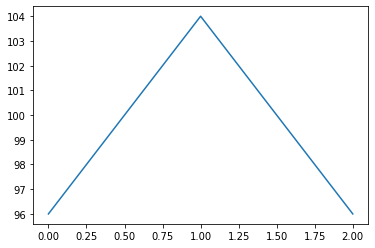

In [10]:
x=decompose_to_two_bin(np.array([800, 4000, 4000, 1200,    0,    0],  np.int_), np.array([599, 824, 191,  84], np.int_))
plt.plot(x)
(max(x)-min(x))/max(x)*100

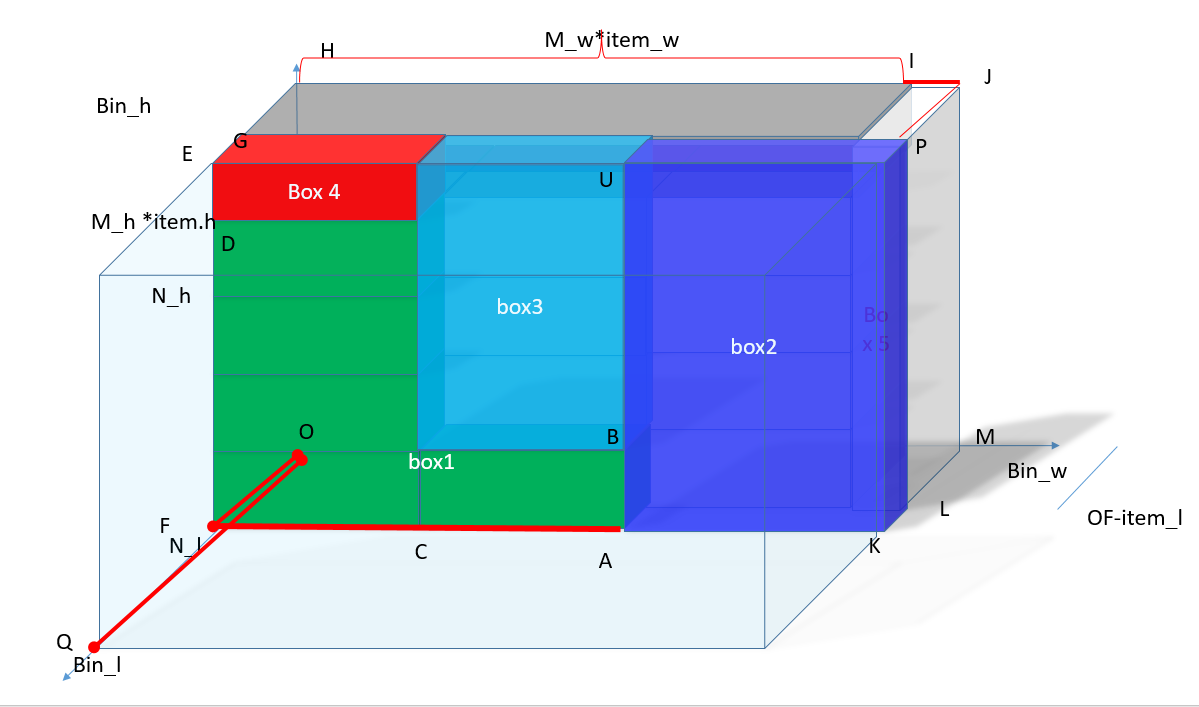

In [11]:
@njit
def decompose_bin(bin_size, item_size) :
    best_fit = find_number_of_rotate_fit(bin_size,item_size)
    boxes = compute_box(bin_size, item_size, best_fit)
    return boxes
@njit

def compute_box(bin_size, item_size, best_fit):#decompose box, input: [size,position]
    box= np.empty((6, 6), np.int_)
    M_lwh, M_l, M_w, M_h, best_rotate = best_fit[0], best_fit[1], best_fit[2], best_fit[3], best_fit[4]
    item_size_rotate = compute_rotate_item_size(item_size, best_rotate)
    item_l, item_w, item_h, item_num = item_size_rotate
    # print(item_size_rotate)
    # print(best_fit)
    if M_lwh==0:
        return box
    bin_l = bin_size[0]
    bin_w= bin_size[1]
    bin_h =bin_size[2]
    bin_pos_l = bin_size[3]
    bin_pos_w= bin_size[4]
    bin_pos_h =bin_size[5]
    
    # print("1")
    temp_num = item_num
    if temp_num>M_lwh:
        temp_num= M_lwh
    OQ= bin_l
    N_l = math.ceil(temp_num/(M_w* M_h)) #8
    num_item_front=temp_num- (N_l-1)*M_w* M_h #20-2*4*2
    OF = N_l*item_l
    # print(N_l)
    # print('need to compute')
    HI = M_w*item_w
    IJ = bin_w-HI
    JP =  math.floor(temp_num/(M_w* M_h))*item_l
    num_colum_face= math.ceil(num_item_front/M_h)
    FA =num_colum_face*item_w
    AB = (M_h-(num_colum_face*M_h-num_item_front))*item_h
    num_box_AB =  num_item_front%(M_h)
    FC= math.floor(num_item_front/M_h )*item_w
    CA = FA-FC

    # print(num_box_AB)
    # print("OF", OF,"FC", FC,"CA","FA",FA, CA, "AB", AB)
    FD= M_h*item_h
    box[0] = [ bin_l-OF, bin_w, bin_h,bin_pos_l+ OF, bin_pos_w, bin_pos_h]
    box[1] = [ item_l, bin_w-FA, bin_h, bin_pos_l + OF- item_l,bin_pos_w+ FA, bin_pos_h]
    box[2] = [ item_l, FA-FC, bin_h- AB, bin_pos_l+ OF-item_l, bin_pos_w + FC,AB+bin_pos_h]

    box[3] = [ item_l, FC, bin_h- FD, bin_pos_l + OF- item_l, bin_pos_w, FD+bin_pos_h]


    box[4] = [ OF- item_l, bin_w-HI, bin_h, bin_pos_l+0,bin_pos_w+HI, bin_pos_h]
    box[5] = [OF- item_l, HI, bin_h-FD, bin_pos_l+0, bin_pos_w, FD +bin_pos_h]


    return box


# draw_packed_bin([5,7,9])

# boxes= decompose_bin(*input)# draw_packed_bin([5,7,9])
# # (bin_size,item_size)
# for box in boxes:
#     print(box)
# [array([ 800, 4000, 4000, 1200,    0,    0]), array([599, 134, 191,   0]), array([-191, 3886,  406, 1200,    0, 3594])]




In [12]:
a=8760 
b=19500 
c=672 
x=684 
y=1095 
z=1535
boxes = decompose_bin(np.array([a, b, c, 0,    0,    0]), np.array([x, y, z,  84])) 
print(find_number_of_rotate_fit(np.array([a, b, c, 0,    0,    0]), np.array([x, y, z,  84])))
print(boxes)

[ 0 12 17  0  0]
[[-3761688987579986997 -3761688987579986997 -3761688987579986997
  -3761688987579986997 -3761688987579986997 -3761688987579986997]
 [-3761688987579986997 -3761688987579986997 -3761688987579986997
  -3761688987579986997 -3761688987579986997 -3761688987579986997]
 [-3761688987579986997 -3761688987579986997 -3761688987579986997
  -3761688987579986997 -3761688987579986997 -3761688987579986997]
 [-3761688987579986997 -3761688987579986997 -3761688987579986997
  -3761688987579986997 -3761688987579986997 -3761688987579986997]
 [-3761688987579986997 -3761688987579986997 -3761688987579986997
  -3761688987579986997 -3761688987579986997 -3761688987579986997]
 [-3761688987579986997 -3761688987579986997  8912361492909901070
  -2591746192355791440 -3012639237291400271  -915301284655661260]]


In [13]:
import plotly.graph_objects as go
import random as rd


def get_random_color():
    return "#%06x" % rd.randint(0, 0xFFFFFF)
color_list = []
for i in range(1000):
    color_list.append(get_random_color())
def draw_packed_bin(bin_size, item_list):
    data = []
    
    data.append(
        go.Mesh3d(
            x=[0, 0, int(bin_size[0]), int(bin_size[0]), 0, 0, int(bin_size[0]), int(bin_size[0])],
            y=[0, int(bin_size[1]), int(bin_size[1]), 0, 0, int(bin_size[1]), int(bin_size[1]), 0],
            z=[0, 0, 0, 0, int(bin_size[2]), int(bin_size[2]), int(bin_size[2]), int(bin_size[2])],
            # Intensity of each vertex, which will be interpolated and color-coded  
            # i, j and k give the vertices of triangles

            # i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            # j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            # k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            showscale=True,
            color="#555",
            opacity=0.1
        )
    )

    for index in range(len((item_list))):
        item= item_list[index]
        ox_item = int(item[3])
        oy_item = int(item[4])
        oz_item = int(item[5])

        # true_size = item.get_dimension()
        
        extreme_x = int(item[0]) + ox_item
        extreme_y = int(item[1]) + oy_item
        extreme_z = int(item[2]) + oz_item
        # print(oz_item,extreme_x)

        data.append(
            go.Mesh3d(
                x=[ox_item, ox_item, extreme_x, extreme_x, ox_item, ox_item, extreme_x, extreme_x],
                y=[oy_item, extreme_y, extreme_y, oy_item, oy_item, extreme_y, extreme_y, oy_item],
                z=[oz_item, oz_item, oz_item, oz_item, extreme_z, extreme_z, extreme_z, extreme_z],
                # Intensity of each vertex, which will be interpolated and color-coded  
                # i, j and k give the vertices of triangles
                i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
                j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
                k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
                # name =  " %s " %(item.name) ,
                showscale = True,
                # color ='red',
                color = get_random_color(),
                hovertext="box "+str(index),
                opacity=1, flatshading = True
            )
        )
        data.append(go.Scatter3d(x=[0], y=[0], z=[0], mode = 'markers'))
   
    fig = go.Figure(data)
    # fig = go.Figure(data=[go.Mesh3d(x=[0], y=[0], z=[0], color='lightpink', opacity=0.50)])
    fig.update_layout(
        autosize=False,
        width=1300,
        height=900,
        scene_aspectmode = 'data', 
        scene_camera = dict( eye=dict(x=-2, y=-2, z=-1))
        )

    fig.show()

In [14]:
bin_list_obj = []
bin_list_obj.append(Bin(np.array([44, 53,63,0,0,0], np.int_) ))
# bin_list_obj.append(Bin(np.array([10000, 200,500,4], np.int_)))
bin_list =[item.size for item in bin_list_obj]
bin_size =  bin_list[0]
item_list_obj=[]
item_list_obj.append(Item(np.array([10, 5,10,205], np.int_)))
item_list = [item.size for item in item_list_obj]
item_size = item_list[0]

input = [bin_size, item_size]
boxes= decompose_bin(*input)# draw_packed_bin([5,7,9])
print(boxes)
draw_packed_bin(bin_size, boxes)


[[ 4 53 63 40  0  0]
 [10 28 63 30 25  0]
 [10  5 53 30 20 10]
 [10 20  3 30  0 60]
 [30  3 63  0 50  0]
 [30 50  3  0  0 60]]


In [15]:
for _ in range(10000):
    a=rd.randint(200,20000)*10
    
    b=rd.randint(200,20000)*10
    
    c=rd.randint(200,2000)
    
    x=rd.randint(200,20000)
    
    y=rd.randint(200,20000)
    
    z=rd.randint(200,20000)
    boxes = decompose_bin(np.array([a, b, c, 0,    0,    0]), np.array([x, y, z,  84])) 
    for box in boxes:
        if box[0] <0 or box[1]<0 or box[2]<0:
            if find_number_of_rotate_fit(np.array([a, b, c, 0,    0,    0]), np.array([x, y, z,  84]))[0]>0:
                print(a,b,c,x,y,z)

In [16]:
bin_list[0] *=2
bin_list
number_item = sum([item[3] for item in item_list ])
number_item
def update_item_pos_list(item_pos_list, item, result_of_packing_item):
    return item_pos_list
sum([item[3] for item in item_list])

205

In [17]:






item_list

[array([399, 104, 599, 108]),
 array([598, 118, 458, 754]),
 array([598, 145, 194, 348]),
 array([597, 123, 542, 744]),
 array([534, 125, 596, 658]),
 array([498, 102, 595, 687]),
 array([154, 118, 592, 528]),
 array([509, 138, 590,  98]),
 array([509, 149, 588, 536]),
 array([588, 133, 465, 547]),
 array([587, 118, 157, 507]),
 array([375, 142, 586, 447]),
 array([230, 129, 586, 264]),
 array([427, 107, 586, 273]),
 array([260, 116, 585,  16]),
 array([585, 143, 116,  21]),
 array([585, 121, 357, 810]),
 array([493, 154, 585, 339]),
 array([358, 104, 584,  85]),
 array([211, 116, 584, 398]),
 array([123, 139, 583, 282]),
 array([583, 104, 116, 601]),
 array([582, 144, 400, 263]),
 array([528, 149, 581, 800]),
 array([208, 125, 581, 742]),
 array([581, 141, 410, 380]),
 array([580, 150, 296,  68]),
 array([535, 111, 578, 100]),
 array([494, 123, 578, 853]),
 array([489, 148, 575, 974]),
 array([147, 145, 574,  87]),
 array([571, 142, 475, 819]),
 array([566, 156, 571, 321]),
 array([27

In [45]:
time1= time.time()
bin_list_obj = []
bin_list_obj.append(Bin(np.array([1000, 2000,2000,0,0,0], np.int_)))
# bin_list_obj.append(Bin(np.array([10000, 200,500,4], np.int_)))
bin_list =[item.size for item in bin_list_obj]

bin_list0=bin_list[0]
item_list_obj = []

for i in range(300):
    x=rd.randint(100, 600)
    y=rd.randint(100, 160)
    z=rd.randint(100, 600)
    t=rd.randint(1, 10000)
    item_list_obj.append(Item(np.array([x, y, z,t], np.int_)))
item_list=[item.size for item in item_list_obj]
min_item_dim  =  min([min(item[0], item[1], item[2])  for item in item_list] )
item_list.sort(key=lambda x:-max(x[0], x[1], x[2]))
time1=time.time()

binsize1= bin_list[0] 
def main(bin_list, item_list):
    left_over_bin = []
    item_pos_list = np.zeros((8, number_item), np.int_)

    for i in range(len(item_list)):
        item = item_list[i]
        temp_bin_list =  []
        if len(bin_list)==0:
            break
        bin_list.sort(key =  lambda x: min(x[0], x[1], x[2])+x[0]+x[1]+x[2])
        for b in range(len(bin_list)):



            if min(bin_list[b][0], bin_list[b][1], bin_list[b][2]) < min_item_dim :
                # left_over_bin.append(bin_list[b])
                continue
            if min(bin_list[b][0], bin_list[b][1], bin_list[b][2]) < min( [item[0], item[1], item[2] ]) :
                temp_bin_list.append(bin_list[b])
                continue

    # boxes = decompose_bin(np.array([a, b, c, 0,    0,    0]), np.array([x, y, z,  84])) 
    # for box in boxes:
    #     if box[0] <0 or box[1]<0 or box[2]<0:
    #         if find_number_of_rotate_fit(np.array([a, b, c, 0,    0,    0]), np.array([x, y, z,  84]))[0]>0:
    #             print(a,b,c,x,y,z)

            result_of_packing_item =  find_number_of_rotate_fit(bin_list[b],item)
            number_of_fit =result_of_packing_item[0]
            if number_of_fit==0:
                temp_bin_list.append(bin_list[b])
                continue
            else:
                box = decompose_bin(bin_list[b],item) 
                item_pos_list =  update_item_pos_list(item_pos_list, item, result_of_packing_item)
                for k in range(len(box)):
                    if min(box[k][0], box[k][1], box[k][2]) <0:
                        left_over_bin.append(  [bin_list[b],item, box[k]])
                        print([bin_list[b],item, box[k]])
                    if min(box[k][0], box[k][1], box[k][2]) < min_item_dim :
                        # print(number_of_fit)
                        

                        continue
                    
                    temp_bin_list.append(box[k])

            
            if item_list[i][3] >= number_of_fit:
                item_list[i][3] = item_list[i][3]- number_of_fit
            else:
                item_list[i][3] =0        
        bin_list= temp_bin_list
    draw_packed_bin(binsize1, bin_list)
    print(left_over_bin)

main(bin_list, item_list)
print(time.time()-time1)

# len(temp_bin_list)

[]
0.015801191329956055


In [19]:
compute_number_of_fit(np.array([2000, 4000, 4000,  600,    0,    0], np.int_), np.array([526, 107, 600,   0], np.int_)  ) 

array([666,   3,  37,   6])

In [20]:
decompose_bin(np.array([1400, 4000, 4000,  600,    0,    0], np.int_), np.array([170, 143, 599,3000], np.int_)) 

array([[  40, 4000, 4000, 1960,    0,    0],
       [ 170,  139, 4000, 1790, 3861,    0],
       [ 170,    0,  406, 1790, 3861, 3594],
       [ 170, 3861,  406, 1790,    0, 3594],
       [1190,  139, 4000,  600, 3861,    0],
       [1190, 3861,  406,  600,    0, 3594]])

0.016881942749023438

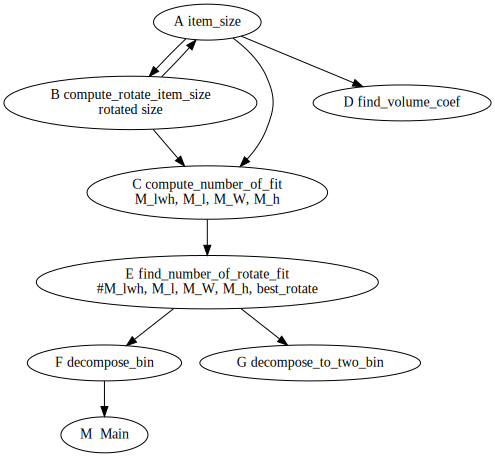

In [21]:

import graphviz


dot = graphviz.Digraph(comment='The Round Table')



dot.node('A', "A item_size")  # doctest: +NO_EXE
dot.node('B', "B compute_rotate_item_size\n rotated size")  # doctest: +NO_EXE
dot.node('C', "C compute_number_of_fit\n M_lwh, M_l, M_W, M_h")  # doctest: +NO_EXE
dot.node('D', "D find_volume_coef")  # doctest: +NO_EXE
dot.node('E', "E find_number_of_rotate_fit\n#M_lwh, M_l, M_W, M_h, best_rotate")  # doctest: +NO_EXE
dot.node('F', "F decompose_bin")  # doctest: +NO_EXE
dot.node('G', "G decompose_to_two_bin")  # doctest: +NO_EXE
dot.node('M', "M  Main")  # doctest: +NO_EXE


dot.edges(['AC', "AD", "AB","BA", "CE", "BC", "EG", "EF", "FM"])
dot

t_obj.append(Item(np.array([350, 500, 600, 10000], np.int_)))
item_list_obj.append(Item(np.array([350, 250, 200,11000], np.int_)))

In [22]:
0.039103031158447266



import plotly.graph_objects as go
import numpy as np
x=0
y=0
z=0
def Three_D_draw(a,b,c,xx,yy,zz):
    fig = go.Figure(data=[
        go.Mesh3d(
        x=[0, 1, 2, 0],
        y=[0, 0, 1, 2],
        z=[0, 2, 0, 1],
        colorbar_title='z',
        colorscale=[[0, 'gold'],
                    [0.5, 'mediumturquoise'],
                    [1, 'magenta']],
        # Intensity of each vertex, which will be interpolated and color-coded
        intensity=[0, 0.33, 0.66, 1],
        # i, j and k give the vertices of triangles
        # here we represent the 4 triangles of the tetrahedron surface
        i=[0, 0, 0, 1],
        j=[1, 2, 3, 2],
        k=[2, 3, 1, 3],
        name='y',
            showscale=True, flatshading = True
        )
    ])

    fig.show()
Three_D_draw(x,y,z,1,1,1)

# cost function
